# Predicting Titanic Survival using K Neighbors Classifier

In this notebook, we will take data from a Kaggle competition 'Titanic - Machine Learning from Disaster' and see if we can use a Logistic Regression Model to get some predictions.

We have two sets of data, train and test, containing almost the same information. Our data consists of the following information:

- PassengerId: a number assigned to each passenger.
- Survived: whether or not this passenger survived.  This is only in the training data.
- Pclass: The passengers class, either first, second or third.
- Name: The name of the passenger.
- Sex: The sex of the passenger.
- Age: The age of the passenger.
- SibSp: The number of siblings or spouses the passenger had also on board.
- Parch: The number of parents or children the passenger had also on board.
- Ticket: A ticket id.
- Fare: The amount paid for the ticket.
- Cabin: The cabin the passenger stayed in.
- Embarked: Where the passenger boarded the Titanic.

We will take this data set and apply a K Neighbors classifier, which is a supervised machine learning algorithm that can be used to solve both classification and regression problems. The classifier works by normalizing the data, and checking a new data point against the points that it already knows.  It computes the distance between these normalized points and classifies the new point based on what the nearest points are.  The k value that is plugged into the classifier decides how many nearby points to take into consideration when classifying the new point. For example, if you have k = 3, the classifier will consider the three nearest points, and based on whether those passengers survived or not, it will group the point with them.  If the majority of the points nearby signifiy survival, the model will classify the new point as someone who survived..

Our goal is to create a K Neighbors classifier model that will be trained on some of our data, and then be able to predict, with a fairly high level of accuracy, whether our testing data contains survivors.

### Table of Contents

 - Exploring and Cleaning the Data
 - Building and Training Our Model
 - Testing Our Model
 - Conclusion

## Exploring and Cleaning the Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [51]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [52]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [54]:
np.mean(train.Age)

29.69911764705882

It is clear that there are some missing values in the age column, which is assumed to be an important factor to whether one survived on the Titanic.  We should try to fill some of those in. We will fill them in with the average age of our passengers, which is a little younger than 30 years old.

In [55]:
train.Age.fillna(value = np.mean(train.Age), inplace = True)

The next thing that we will tackle is the class system.  It will be difficult to work with the class column as it is. Instead of having it be a column containing a number 1 through 3, we will add columns that will contain a 0 or a 1 for whether that passenger was of the class contained in the column.

In [56]:
train['FirstClass'] = train['Pclass'].apply(lambda x: 1 if x == 1 else 0)
train['SecondClass'] = train['Pclass'].apply(lambda x: 1 if x == 2 else 0)
train['ThirdClass'] = train['Pclass'].apply(lambda x: 1 if x == 3 else 0)
train.drop(columns = ['Pclass'])

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstClass,SecondClass,ThirdClass
0,1,0,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,NaN,S,0,1,0
887,888,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,B42,S,1,0,0
888,889,0,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,NaN,S,0,0,1
889,890,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C148,C,1,0,0


Then we will make it easier to work with the sex of the passengers.  If a passenger is male, the column Sex will now contain a 0, and if the passenger is female it will contain a 1.

In [57]:
train['Sex'] = train['Sex'].apply(lambda x: 1 if x == 'female' else 0)

In [58]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstClass,SecondClass,ThirdClass
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,1,0,0
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0,0,1


We want to do the same thing to our test data as the data we use to train our model, so let's take care of that now.

In [59]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [60]:
test.Age.fillna(value = np.mean(test.Age), inplace = True)

test['FirstClass'] = test['Pclass'].apply(lambda x: 1 if x == 1 else 0)
test['SecondClass'] = test['Pclass'].apply(lambda x: 1 if x == 2 else 0)
test['ThirdClass'] = test['Pclass'].apply(lambda x: 1 if x == 3 else 0)
train.drop(columns = ['Pclass'])

test['Sex'] = test['Sex'].apply(lambda x: 1 if x == 'female' else 0)

There is one entry that contains a null value for fare in our testing set.  Let's look into that more and try to fill it.

In [61]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FirstClass,SecondClass,ThirdClass
152,1044,3,"Storey, Mr. Thomas",0,60.5,0,0,3701,NaN,NaN,S,0,0,1


We can see that this was a third class passenger, so lets take the average fare of third class passengers and use that to fill his fair.

In [62]:
avg_thirdclass_fare = np.mean(test.Fare[test['ThirdClass'] == 1])
avg_thirdclass_fare

12.459677880184334

In [63]:
test.Fare.fillna(value = avg_thirdclass_fare, inplace = True)

Now that our data is clean and easier to use, let's try to make, train and test our model.

## Making, Training and Using our Model

Not all of this data will help us figure out if someone survived on the Titanic.  We will select out features that we want our model to consider when making its predictions.  Those will be age, sex, fare and passenger class.

In [64]:
features = train[['Sex', 'Age', 'Fare', 'FirstClass', 'SecondClass', 'ThirdClass']]
survived = train['Survived']

testing = test[['Sex', 'Age', 'Fare', 'FirstClass', 'SecondClass', 'ThirdClass']]

We will split up our training data so that we can test our accuracy on our own to optimize the model, then train with all our training data and get out predictions we can submit to Kaggle.

In [65]:
training_set, validation_set, training_labels, validation_labels = train_test_split(features, survived, test_size = 0.2, random_state = 100)

In [66]:
print(training_set.shape)
print(training_labels.shape)
print(validation_set.shape)
print(validation_labels.shape)

(712, 6)
(712,)
(179, 6)
(179,)


Now we can build and train our model.

In [67]:
classifier = KNeighborsClassifier(n_neighbors = 3)
classifier.fit(training_set, training_labels)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Alright, now we have fit our data, let's check the score based on the set aside training data.

In [68]:
score = classifier.score(validation_set, validation_labels)
print(score)

0.7262569832402235


Let's see if we can make it better with a different k.

In [69]:
accuracies= []
for k in range(1, 101):
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(training_set, training_labels)
  accuracies.append(classifier.score(validation_set, validation_labels))

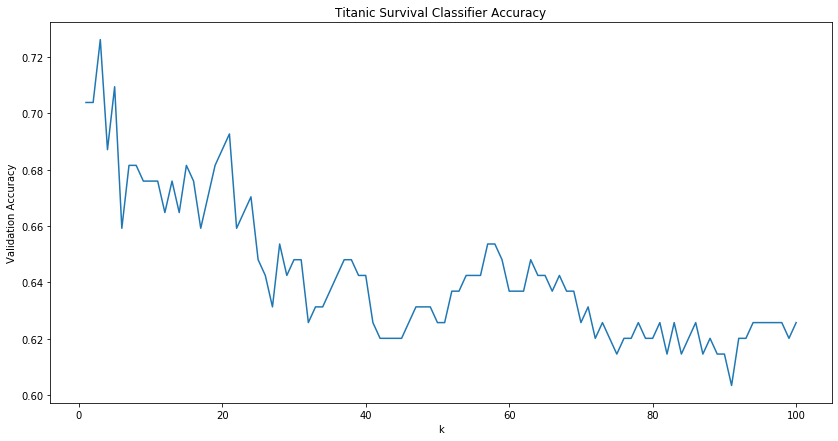

In [70]:
k_list = range(1, 101)
plt.figure(figsize = (14, 7))
plt.plot(k_list, accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.title('Titanic Survival Classifier Accuracy')
plt.show()

So we can see that the accuracy goes down the higher the k value, so let's see what gave the highest.

In [71]:
accuracies[0:10]

[0.7039106145251397,
 0.7039106145251397,
 0.7262569832402235,
 0.6871508379888268,
 0.7094972067039106,
 0.659217877094972,
 0.6815642458100558,
 0.6815642458100558,
 0.6759776536312849,
 0.6759776536312849]

k = 3 is the highest accuracy, so that is as good as this model will get for now.

## Conclusion

We were able to build a K Neighbors classifier that could predict whether a passenger would survive the sinking of the Titanic with an accuracy of 0.72, and check what k value gave us that highest accuracy score.